In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt

In [3]:
from fundamental_matrix import keypoint_matcher, get_fundamental_matrix, draw_epipolar_lines

# Matching

In [47]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000049.png")

Before filtering neighbours: 543. After: 154


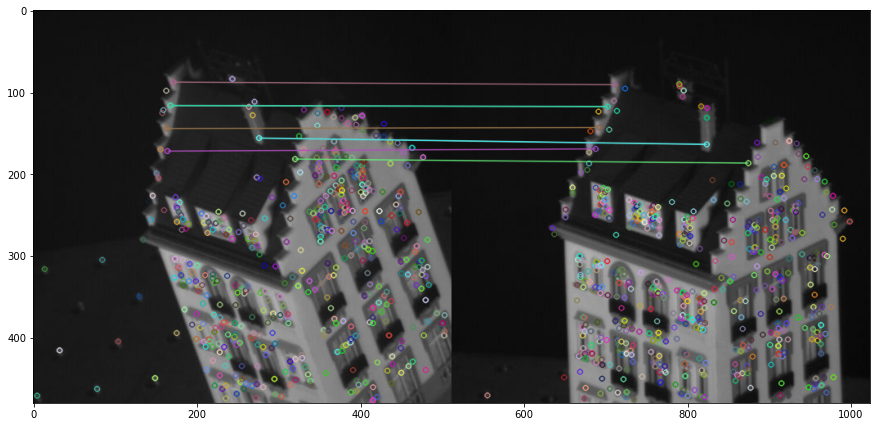

In [59]:
matches, matched_points1, matched_points2, kp1, kp2 = keypoint_matcher(image1, image2, 
                                                                       n_points=8, 
                                                                       random_selection=False, 
                                                                       filter_neighbours=True, 
                                                                       draw_matches=True)

In [60]:
matched_points1

[(167.96371459960938, 116.2098159790039),
 (167.96371459960938, 116.2098159790039),
 (276.1034851074219, 155.9117889404297),
 (164.10728454589844, 171.78672790527344),
 (171.3076934814453, 87.54822540283203),
 (162.98277282714844, 144.24075317382812),
 (276.1034851074219, 155.9117889404297),
 (320.30938720703125, 181.56515502929688)]

In [61]:
matched_points2

[(190.5642547607422, 117.45438385009766),
 (190.5642547607422, 117.45438385009766),
 (311.77545166015625, 163.61129760742188),
 (175.87417602539062, 169.19515991210938),
 (199.7759552001953, 90.6645278930664),
 (180.32879638671875, 142.99551391601562),
 (311.77545166015625, 163.61129760742188),
 (362.681884765625, 186.52915954589844)]

# Normalization

In [117]:
def normalize_points(matched_points):
    mx = np.mean([p[0] for p in matched_points])
    my = np.mean([p[1] for p in matched_points])
    d = sum([np.sqrt((p[0] - mx)**2 + (p[1] - my)**2) for p in matched_points]) / len(matched_points)
    print(f"mean x: {round(mx, 3)}, mean y: {round(my, 3)}, average distance to the mean: {round(d, 3)}")

    coef = np.sqrt(2)/d

    T = np.array([[coef, 0, -mx*coef],
                  [0, coef, -my*coef],
                  [0, 0, 1]])
    
    result_list = []
    for p_i in matched_points:
        p_i = np.array([p_i[0], p_i[1], 1])        
        p_i_hat = np.dot(T, p_i)
        result_list.append((p_i_hat[0], p_i_hat[1]))
        
    return result_list, T

In [118]:
matched_points1_norm, T = normalize_points(matched_points1)

mean x: 213.355, mean y: 141.173, average distance to the mean: 65.43


Check and show that the set of points {p_hat} with homogeneous coordinates satisfies our criteria.

In [119]:
normalize_points(matched_points1_norm);

mean x: 0.0, mean y: 0.0, average distance to the mean: 1.414


In [120]:
matched_points2_norm, T_prime = normalize_points(matched_points2)

mean x: 240.418, mean y: 143.939, average distance to the mean: 73.353


In [121]:
normalize_points(matched_points2_norm);

mean x: -0.0, mean y: -0.0, average distance to the mean: 1.414


# Fundamental matrix

In [128]:
F = get_fundamental_matrix(matched_points1, matched_points2, normalize=False)
F

U, D, V_t = np.linalg.svd(A) (8, 8) (8,) (9, 9)
V_t.T[:, n - 1]
[ 7.88878075e-05 -2.24914607e-03  2.22355172e-02  1.74750335e-03
  3.65755402e-04 -6.98517520e-01 -4.27481254e-02  7.12587640e-01
  4.42951169e-02]
(9,)
F
[[ 7.88878075e-05 -2.24914607e-03  2.22355172e-02]
 [ 1.74750335e-03  3.65755402e-04 -6.98517520e-01]
 [-4.27481254e-02  7.12587640e-01  4.42951169e-02]]
(3, 3)
FD_prime [7.29950731e-01 6.83499766e-01 6.38147320e-07]
FD_prime with the smallest singular value zeroed [0.72995073 0.68349977 0.        ]


array([[ 7.82511310e-05, -2.24918416e-03,  2.22355156e-02],
       [ 1.74748296e-03,  3.65754182e-04, -6.98517520e-01],
       [-4.27481273e-02,  7.12587640e-01,  4.42951169e-02]])

In [129]:
cv.findFundamentalMat(np.float32(matched_points1), np.float32(matched_points2), cv.FM_LMEDS)

(array([[ 1.60195550e-05,  5.48964550e-06, -1.91191447e-04],
        [-4.80053635e-06, -5.40886587e-07,  2.59365168e-04],
        [-9.84794236e-03,  1.44733541e-03,  1.00000000e+00]]),
 array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8))

In [131]:
cv.findFundamentalMat(np.float64(matched_points1), np.float64(matched_points2), cv.FM_8POINT)

(array([[ 7.27668545e-05,  1.25158722e-04, -4.30839377e-02],
        [-1.42217182e-04, -6.28253676e-05,  8.12128243e-02],
        [-6.63383351e-04, -3.80420558e-02,  1.00000000e+00]]),
 array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8))

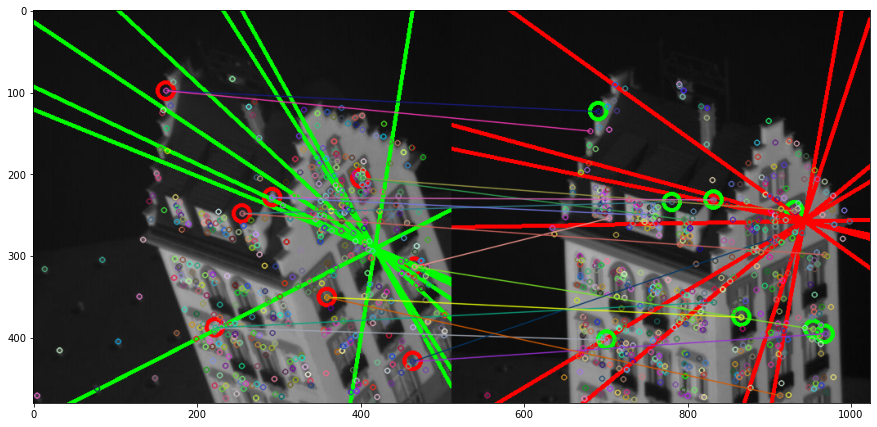

In [107]:
draw_epipolar_lines(image1, image2, matches, kp1, kp2, F)

# Chaining

Construct a point-view matrix for chaining multiple views with the matches found in last step using all consecutive house images (1-2, 2-3, 3-4, ..., 48-49, 49-1). Rows of the point-view matrix will be representing your images while columns will be points. For more details, you can refer to [2].
1. Start from any two consecutive image matches. Add a new column to point-view matrix for each newly introduced point.
2. If a point which is already introduced in the point-view matrix and another image contains that point, mark this matching on your point-view matrix using the previously defined point column. Do not introduce a new column.  

Together with the assignment a sample point view matrix (PointViewMatrix.txt) is provided to test and finish your pipeline (for the ones who have difficult time to build a point view matrix). This data has more images than provided for the assignment, however you can still use PVM to check correctness of the last part of your algorithm.

In [62]:
from chaining import get_names_image_pair, chaining

In [63]:
PVM = chaining(n_points=8)

  4%|▍         | 2/49 [00:00<00:04,  9.58it/s]

comparing table x indices (0, 2) and images ('../Data/House/frame00000001.png', '../Data/House/frame00000002.png')
Before filtering neighbours: 543. After: 450
comparing table x indices (2, 4) and images ('../Data/House/frame00000002.png', '../Data/House/frame00000003.png')
Before filtering neighbours: 548. After: 447


  6%|▌         | 3/49 [00:00<00:05,  8.79it/s]

comparing table x indices (4, 6) and images ('../Data/House/frame00000003.png', '../Data/House/frame00000004.png')
Before filtering neighbours: 526. After: 424
comparing table x indices (6, 8) and images ('../Data/House/frame00000004.png', '../Data/House/frame00000005.png')


 10%|█         | 5/49 [00:00<00:04,  9.20it/s]

Before filtering neighbours: 566. After: 450
comparing table x indices (8, 10) and images ('../Data/House/frame00000005.png', '../Data/House/frame00000006.png')
Before filtering neighbours: 525. After: 424
comparing table x indices (10, 12) and images ('../Data/House/frame00000006.png', '../Data/House/frame00000007.png')


 14%|█▍        | 7/49 [00:00<00:04,  9.40it/s]

Before filtering neighbours: 554. After: 437
comparing table x indices (12, 14) and images ('../Data/House/frame00000007.png', '../Data/House/frame00000008.png')
Before filtering neighbours: 534. After: 434
comparing table x indices (14, 16) and images ('../Data/House/frame00000008.png', '../Data/House/frame00000009.png')


 18%|█▊        | 9/49 [00:00<00:04,  9.03it/s]

Before filtering neighbours: 540. After: 448
comparing table x indices (16, 18) and images ('../Data/House/frame00000009.png', '../Data/House/frame00000010.png')
Before filtering neighbours: 561. After: 455
comparing table x indices (18, 20) and images ('../Data/House/frame00000010.png', '../Data/House/frame00000011.png')


 22%|██▏       | 11/49 [00:01<00:04,  8.89it/s]

Before filtering neighbours: 549. After: 453
comparing table x indices (20, 22) and images ('../Data/House/frame00000011.png', '../Data/House/frame00000012.png')
Before filtering neighbours: 550. After: 440
comparing table x indices (22, 24) and images ('../Data/House/frame00000012.png', '../Data/House/frame00000013.png')


 27%|██▋       | 13/49 [00:01<00:04,  8.78it/s]

Before filtering neighbours: 555. After: 452
comparing table x indices (24, 26) and images ('../Data/House/frame00000013.png', '../Data/House/frame00000014.png')
Before filtering neighbours: 558. After: 450
comparing table x indices (26, 28) and images ('../Data/House/frame00000014.png', '../Data/House/frame00000015.png')


 31%|███       | 15/49 [00:01<00:03,  8.52it/s]

Before filtering neighbours: 573. After: 479
comparing table x indices (28, 30) and images ('../Data/House/frame00000015.png', '../Data/House/frame00000016.png')
Before filtering neighbours: 573. After: 457
comparing table x indices (30, 32) and images ('../Data/House/frame00000016.png', '../Data/House/frame00000017.png')


 35%|███▍      | 17/49 [00:01<00:03,  8.11it/s]

Before filtering neighbours: 549. After: 458
comparing table x indices (32, 34) and images ('../Data/House/frame00000017.png', '../Data/House/frame00000018.png')
Before filtering neighbours: 571. After: 476
comparing table x indices (34, 36) and images ('../Data/House/frame00000018.png', '../Data/House/frame00000019.png')


 39%|███▉      | 19/49 [00:02<00:03,  8.72it/s]

Before filtering neighbours: 584. After: 475
comparing table x indices (36, 38) and images ('../Data/House/frame00000019.png', '../Data/House/frame00000020.png')
Before filtering neighbours: 561. After: 462
comparing table x indices (38, 40) and images ('../Data/House/frame00000020.png', '../Data/House/frame00000021.png')


 43%|████▎     | 21/49 [00:02<00:03,  8.49it/s]

Before filtering neighbours: 579. After: 469
comparing table x indices (40, 42) and images ('../Data/House/frame00000021.png', '../Data/House/frame00000022.png')
Before filtering neighbours: 574. After: 478
comparing table x indices (42, 44) and images ('../Data/House/frame00000022.png', '../Data/House/frame00000023.png')


 47%|████▋     | 23/49 [00:02<00:02,  8.97it/s]

Before filtering neighbours: 560. After: 434
comparing table x indices (44, 46) and images ('../Data/House/frame00000023.png', '../Data/House/frame00000024.png')
Before filtering neighbours: 565. After: 452
comparing table x indices (46, 48) and images ('../Data/House/frame00000024.png', '../Data/House/frame00000025.png')


 51%|█████     | 25/49 [00:02<00:02,  8.86it/s]

Before filtering neighbours: 590. After: 485
comparing table x indices (48, 50) and images ('../Data/House/frame00000025.png', '../Data/House/frame00000026.png')
Before filtering neighbours: 572. After: 458
comparing table x indices (50, 52) and images ('../Data/House/frame00000026.png', '../Data/House/frame00000027.png')


 55%|█████▌    | 27/49 [00:03<00:02,  8.77it/s]

Before filtering neighbours: 555. After: 441
comparing table x indices (52, 54) and images ('../Data/House/frame00000027.png', '../Data/House/frame00000028.png')
Before filtering neighbours: 579. After: 435
comparing table x indices (54, 56) and images ('../Data/House/frame00000028.png', '../Data/House/frame00000029.png')


 59%|█████▉    | 29/49 [00:03<00:02,  8.18it/s]

Before filtering neighbours: 578. After: 460
comparing table x indices (56, 58) and images ('../Data/House/frame00000029.png', '../Data/House/frame00000030.png')
Before filtering neighbours: 543. After: 445
comparing table x indices (58, 60) and images ('../Data/House/frame00000030.png', '../Data/House/frame00000031.png')


 63%|██████▎   | 31/49 [00:03<00:02,  7.81it/s]

Before filtering neighbours: 567. After: 455
comparing table x indices (60, 62) and images ('../Data/House/frame00000031.png', '../Data/House/frame00000032.png')
Before filtering neighbours: 552. After: 441
comparing table x indices (62, 64) and images ('../Data/House/frame00000032.png', '../Data/House/frame00000033.png')


 67%|██████▋   | 33/49 [00:03<00:01,  8.22it/s]

Before filtering neighbours: 574. After: 469
comparing table x indices (64, 66) and images ('../Data/House/frame00000033.png', '../Data/House/frame00000034.png')
Before filtering neighbours: 580. After: 436
comparing table x indices (66, 68) and images ('../Data/House/frame00000034.png', '../Data/House/frame00000035.png')


 71%|███████▏  | 35/49 [00:04<00:01,  7.98it/s]

Before filtering neighbours: 546. After: 439
comparing table x indices (68, 70) and images ('../Data/House/frame00000035.png', '../Data/House/frame00000036.png')
Before filtering neighbours: 571. After: 438
comparing table x indices (70, 72) and images ('../Data/House/frame00000036.png', '../Data/House/frame00000037.png')


 76%|███████▌  | 37/49 [00:04<00:01,  7.97it/s]

Before filtering neighbours: 543. After: 454
comparing table x indices (72, 74) and images ('../Data/House/frame00000037.png', '../Data/House/frame00000038.png')
Before filtering neighbours: 567. After: 453
comparing table x indices (74, 76) and images ('../Data/House/frame00000038.png', '../Data/House/frame00000039.png')


 80%|███████▉  | 39/49 [00:04<00:01,  8.36it/s]

Before filtering neighbours: 567. After: 458
comparing table x indices (76, 78) and images ('../Data/House/frame00000039.png', '../Data/House/frame00000040.png')
Before filtering neighbours: 559. After: 452
comparing table x indices (78, 80) and images ('../Data/House/frame00000040.png', '../Data/House/frame00000041.png')


 84%|████████▎ | 41/49 [00:04<00:00,  8.29it/s]

Before filtering neighbours: 586. After: 465
comparing table x indices (80, 82) and images ('../Data/House/frame00000041.png', '../Data/House/frame00000042.png')
Before filtering neighbours: 583. After: 481
comparing table x indices (82, 84) and images ('../Data/House/frame00000042.png', '../Data/House/frame00000043.png')


 88%|████████▊ | 43/49 [00:05<00:00,  8.35it/s]

Before filtering neighbours: 577. After: 458
comparing table x indices (84, 86) and images ('../Data/House/frame00000043.png', '../Data/House/frame00000044.png')
Before filtering neighbours: 563. After: 449
comparing table x indices (86, 88) and images ('../Data/House/frame00000044.png', '../Data/House/frame00000045.png')


 92%|█████████▏| 45/49 [00:05<00:00,  8.44it/s]

Before filtering neighbours: 537. After: 446
comparing table x indices (88, 90) and images ('../Data/House/frame00000045.png', '../Data/House/frame00000046.png')
Before filtering neighbours: 587. After: 481
comparing table x indices (90, 92) and images ('../Data/House/frame00000046.png', '../Data/House/frame00000047.png')


 96%|█████████▌| 47/49 [00:05<00:00,  8.34it/s]

Before filtering neighbours: 578. After: 462
comparing table x indices (92, 94) and images ('../Data/House/frame00000047.png', '../Data/House/frame00000048.png')
Before filtering neighbours: 563. After: 452
comparing table x indices (94, 96) and images ('../Data/House/frame00000048.png', '../Data/House/frame00000049.png')


100%|██████████| 49/49 [00:05<00:00,  8.47it/s]

Before filtering neighbours: 556. After: 439
comparing table x indices (96, 0) and images ('../Data/House/frame00000049.png', '../Data/House/frame00000001.png')
Before filtering neighbours: 554. After: 121


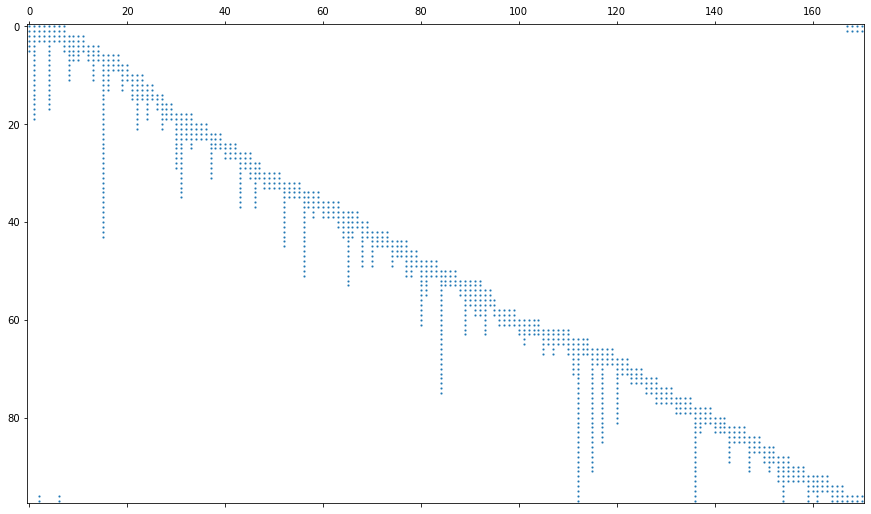

In [64]:
# Implementation of matplotlib spy function
import matplotlib.pyplot as plt
import numpy as np
 
    
plt.figure(figsize=(15, 10))
plt.spy(PVM, precision=1e-4, markersize = 1);

In [65]:
PVM.shape

(98, 171)

In [66]:
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:" + fmt + "}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:" + str(col_maxes[i]) + fmt + "}").format(y), end="  ")
        print("")
        
matprint(PVM[:10, :10])

277.216  159.942  167.964  273.199  282.926  189.718  171.308  255.845  -0.0001  -0.0001  
 205.42  244.005   116.21  204.016  311.843  260.836  87.5482  248.145  -0.0001  -0.0001  
279.066  159.836  168.094  273.998  283.851  189.809  171.511  256.952  223.439  382.787  
206.034  243.891  116.176   204.67  312.582  260.851  87.5413   248.31  260.187  179.234  
279.066  159.875  -0.0001  -0.0001  284.149  -0.0001  -0.0001  256.952  223.732   383.92  
206.034  243.898  -0.0001  -0.0001  312.611  -0.0001  -0.0001   248.31  260.146  180.272  
-0.0001  159.862  -0.0001  -0.0001   284.46  -0.0001  -0.0001  -0.0001  223.932   383.92  
-0.0001  243.884  -0.0001  -0.0001  312.917  -0.0001  -0.0001  -0.0001  260.269  180.272  
-0.0001  159.771  -0.0001  -0.0001  284.631  -0.0001  -0.0001  -0.0001  224.134  -0.0001  
-0.0001   243.61  -0.0001  -0.0001  313.003  -0.0001  -0.0001  -0.0001  260.237  -0.0001  


In [75]:
matprint(PVM[(PVM.round(2) == 277.21).any(axis=1), :])

-0.0001  159.592  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  251.468  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  386.696  -0.0001  224.9  -0.0001  -0.0001  176.744  277.207  180.782  284.029  286.148  258.2  309.456  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.0001  -0.00

## Comparing with PointViewMatrix.txt

In [74]:
gt_pvm = np.loadtxt('../PointViewMatrix.txt')
gt_pvm.shape

(202, 215)

In [32]:
matprint(gt_pvm[:10, :10])

   245     192     201     164     254     281     301     144     314     328  
   281     263     243     229     260     294     307     260     222     136  
245.34  192.15  201.17  164.03  254.51   281.5  301.53  143.87  314.73  328.96  
281.33  263.12  243.06  228.91  260.26  294.52  307.47   259.9  222.54  136.63  
245.63  192.19  201.35   164.1  254.84  281.88  301.91  143.71  315.52  330.12  
281.52  263.29  242.94  228.79  260.16  294.74  307.55  260.04  222.67  136.81  
245.88  192.27  201.51  164.08  255.17  282.23  302.27  143.54   316.2  331.22  
281.69  263.43  242.68   228.5  259.89  294.94  307.51  260.09  222.68   136.9  
246.08  192.31  201.66  164.15  255.51  282.53  302.58  143.37  316.94  332.36  
281.96  263.65  242.66  228.48  259.88   295.2  307.65  260.31   222.9   137.2  


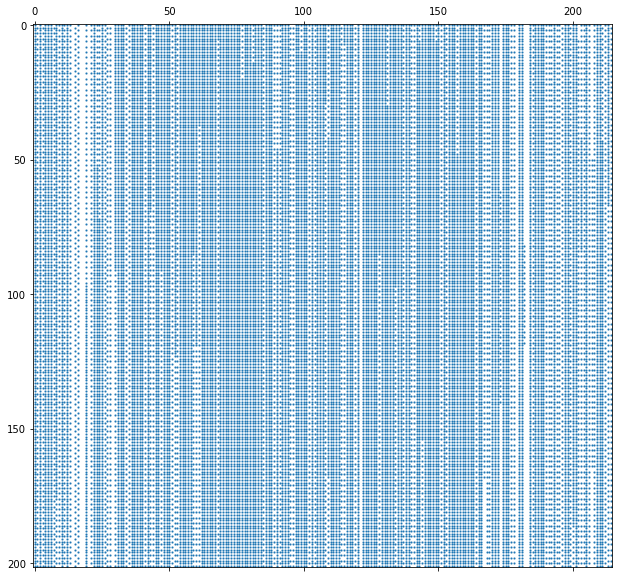

In [43]:
plt.figure(figsize=(15, 10))
plt.spy(gt_pvm, precision=200, markersize = 1);

In [78]:
def flatten_list(ls):
    import itertools
    return list(itertools.chain.from_iterable(ls))

In [86]:
orig = set(flatten_list(PVM.round(2)))
gt = set(flatten_list(gt_pvm.round(2)[:100, :]))
len(orig), len(gt)

(919, 15974)

In [87]:
len(orig.intersection(gt))

443

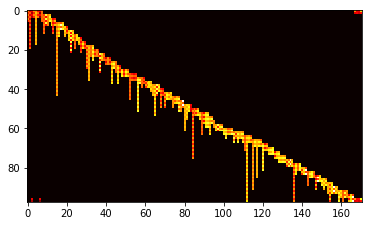

In [88]:
plt.imshow(PVM.round(2), cmap='hot', interpolation='nearest')
plt.show()

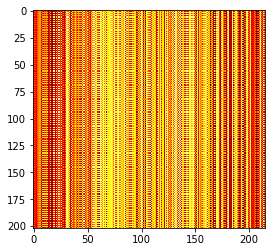

In [89]:
plt.imshow(gt_pvm.round(2), cmap='hot', interpolation='nearest')
plt.show()

# Chaining check

Before filtering neighbours: 543. After: 450
Before filtering neighbours: 548. After: 447


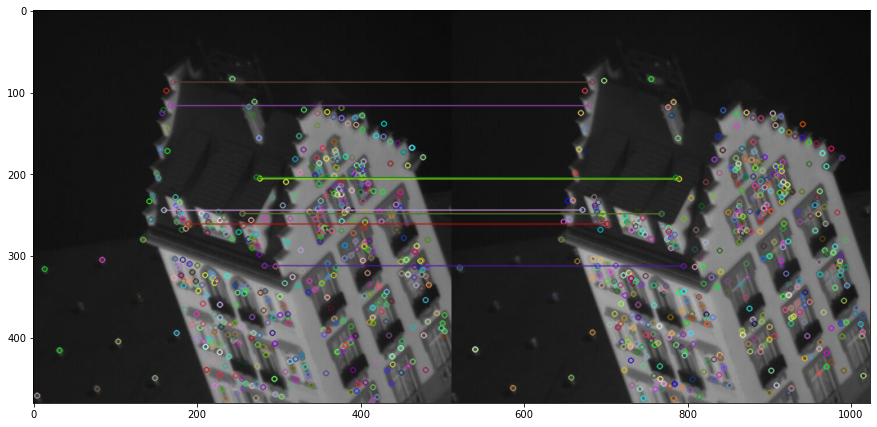

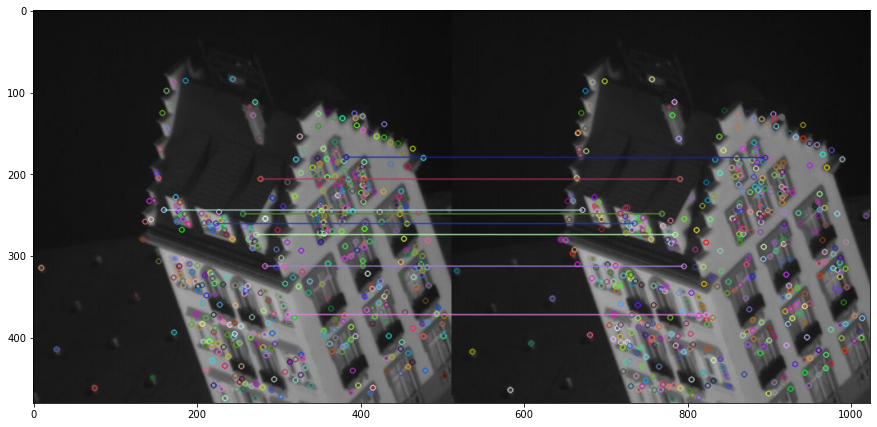

In [141]:
image1 = cv.imread("../Data/House/frame00000001.png")
image2 = cv.imread("../Data/House/frame00000002.png")
image3 = cv.imread("../Data/House/frame00000003.png")

_, matched_points12, matched_points21, _, _ = keypoint_matcher(
    image1, image2, n_points=8, random_selection=False, filter_neighbours=True, draw_matches=True)

_, matched_points23, matched_points32, _, _ = keypoint_matcher(
    image2, image3, n_points=8, random_selection=False, filter_neighbours=True, draw_matches=True)

In [144]:
sorted(matched_points21, key=lambda x: x[0])

[(159.84326171875, 243.7429656982422),
 (168.09413146972656, 116.17607879638672),
 (171.5107879638672, 87.54129791259766),
 (189.80917358398438, 260.8506774902344),
 (256.4742431640625, 248.44085693359375),
 (273.99774169921875, 204.6702880859375),
 (277.9999084472656, 205.9047088623047),
 (283.4146728515625, 312.2811279296875)]

In [145]:
sorted(matched_points23, key=lambda x: x[0])

[(159.84326171875, 243.7429656982422),
 (223.43911743164062, 260.18743896484375),
 (256.4742431640625, 248.44085693359375),
 (272.61663818359375, 273.8099670410156),
 (277.9999084472656, 205.9047088623047),
 (283.4146728515625, 312.2811279296875),
 (311.4600830078125, 371.3696594238281),
 (382.78680419921875, 179.23373413085938)]

In [11]:
PVM[2, :20]

array([ 2.77999908e+02,  1.59843262e+02,  1.68094131e+02,  2.73997742e+02,
        2.83414673e+02,  1.89809174e+02,  1.71510788e+02,  2.56474243e+02,
        2.23439117e+02,  3.82786804e+02,  2.77999908e+02,  2.72616638e+02,
        2.83414673e+02,  3.11460083e+02,  2.56474243e+02,  1.59843262e+02,
       -1.00000000e-04, -1.00000000e-04, -1.00000000e-04, -1.00000000e-04])

In [12]:
PVM[3, :20]

array([ 2.05904709e+02,  2.43742966e+02,  1.16176079e+02,  2.04670288e+02,
        3.12281128e+02,  2.60850677e+02,  8.75412979e+01,  2.48440857e+02,
        2.60187439e+02,  1.79233734e+02,  2.05904709e+02,  2.73809967e+02,
        3.12281128e+02,  3.71369659e+02,  2.48440857e+02,  2.43742966e+02,
       -1.00000000e-04, -1.00000000e-04, -1.00000000e-04, -1.00000000e-04])